# Start


In [425]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from typing import Optional


file_path: str = "../dataset"
files: tuple[str, ...] = ("connections", "devices", "processes", "profiles")

dataset: dict[str, pd.DataFrame] = {}
for file in files:
    dataset[file] = pd.read_csv(f"{file_path}/{file}.csv", sep="\t")

-   importing the necessary libraries
-   declaring the variables


# A.)


### Connections description


In [ ]:
dataset["connections"].info()

-   Total Entries: 15,108
-   Total Columns: 13
-   Column Types:
-   11 columns of type float64
-   1 column of type int64
-   1 column of type object
-   There are no missing values in this data


In [ ]:
dataset["connections"]["ts"]

-   The object column "ts" is date and time


In [ ]:
connection_summary = dataset["connections"].describe()
median = (
    dataset["connections"].select_dtypes(include=["float64", "int64"]).median()
)  # adding median to describe method output
connection_summary.loc["median"] = median

# dropping imei, as it has no meaning to make these statistics out of it
connection_summary.drop(columns=["imei"], inplace=True)
connection_summary

-   From these tables above we can see imei is a long integer and looks like an Id, if we look at processes table, we can also see same values indicating this could be an Id of device.
-   Another assumption we can make is that columns specifying a connection type (columns starting with c. such as c.android.youtube) have values ranging from 0 to 100, this could indicate that it is a percentage amount of time that the connection was established.


-   First few rows might indicate that the data was sample in a 1 minute interval.
-   Let's look at it closer.


In [ ]:
dataset["connections"].sort_values(by="ts", ascending=True)["ts"]

-   Now we see it looks like samples are in a 1 minute interval.
-   Let's go further.


In [ ]:
times = dataset["connections"].sort_values(by="ts")["ts"]
times = pd.to_datetime(times)

previous_time: Optional[pd.Series] = None

same_times: int = 0
non_minute_differences: int = 0


for current_time in times:
    if previous_time is None:
        previous_time = current_time
        continue

    if (current_time - previous_time).seconds == 0:
        same_times += 1

    elif (current_time - previous_time).seconds != 60:
        non_minute_differences += 1

    previous_time = current_time

print(f"Non minute differences: {non_minute_differences}")
print(f"Same times: {same_times}")

-   From this we can see, that there are data every minute, sometimes more than once at the same time.


In [ ]:
times = (
    dataset["connections"]
    .groupby(by="imei")[["imei", "ts"]]
    .apply(lambda x: x.sort_values(by="ts", ascending=True))
    .reset_index(drop=True)
)
times

-   If we assume that columns starting with "c." are representing percentage amount of time being active during a time window, we need to group them by device serial number (imei) and then look at the time difference.


In [ ]:
dataset["connections"]["mwra"].value_counts()

-   mwra is (Malware-related-activity)
-   In data there are only values 1.0 and 0.0 indicating if there was a malware activity in specific time frame.


### Devices description


In [ ]:
dataset["devices"].info()

In [ ]:
devices_summary = dataset["devices"].describe()
median = (
    dataset["devices"].select_dtypes(include=["float64", "int64"]).median()
)  # adding median to describe method output
devices_summary.loc["median"] = median

# dropping imei, as it has no meaning to make these statistics out of it
devices_summary.drop(columns=["imei"], inplace=True)
devices_summary

In [ ]:
dataset["devices"].head()

-   "store_name" object is a string
-   "code" is string, holding code for state
-   "location" is a string, containing continent and city


### Processes description


In [ ]:
dataset["processes"].info()

In [ ]:
processes_summary = dataset["processes"].describe()
median = (
    dataset["processes"].select_dtypes(include=["float64", "int64"]).median()
)  # adding median to describe method output
processes_summary.loc["median"] = median

# dropping imei, as it has no meaning to make these statistics out of it
processes_summary.drop(columns=["imei"], inplace=True)
processes_summary

In [ ]:
dataset["processes"].head()

### Profiles description


In [ ]:
dataset["profiles"].info()

In [ ]:
profiles_summary = dataset["profiles"].describe()
median = (
    dataset["profiles"].select_dtypes(include=["float64", "int64"]).median()
)  # adding median to describe method output
profiles_summary.loc["median"] = median

# dropping imei, as it has no meaning to make these statistics out of it
profiles_summary.drop(columns=["imei"], inplace=True)
profiles_summary

In [ ]:
dataset["profiles"].head()

# B


### MWRA


-   First we look at the most important column "mwra" and look at it more in depth.


In [ ]:
dataset["connections"]["mwra"].value_counts(normalize=True) * 100

-   In "connections" we can see that positive mwra is ~62%, indicating that there are more positive cases and therefore in future when we put it into our model might falsely evaluate some connections. I would say the closer we are to 50/50 the better.


In [ ]:
dataset["processes"]["mwra"].value_counts(normalize=True) * 100

-   "mwra" is the same for "processes" as it is for "connections"


### Declaring and Initializing variables for further use.


In [444]:
chrome_data = dataset["connections"]["c.android.chrome"]
chrome_mean = chrome_data.mean()
chrome_std = chrome_data.std()

dogalize_data = dataset["connections"]["c.dogalize"]
dogalize_mean = dogalize_data.mean()
dogalize_std = dogalize_data.std()

gm_data = dataset["connections"]["c.android.gm"]
gm_mean = gm_data.mean()
gm_std = gm_data.std()

youtube_data = dataset["connections"]["c.android.youtube"]
youtube_mean = youtube_data.mean()
youtube_std = youtube_data.std()

katana_data = dataset["connections"]["c.katana"]
katana_mean = katana_data.mean()
katana_std = katana_data.std()

raider_data = dataset["connections"]["c.raider"]
raider_mean = raider_data.mean()
raider_std = raider_data.std()

vending_data = dataset["connections"]["c.android.vending"]
vending_mean = vending_data.mean()
vending_std = vending_data.std()

x86_data = dataset["connections"]["c.UCMobile.x86"]
x86_mean = x86_data.mean()
x86_std = x86_data.std()


updateassist_data = dataset["connections"]["c.updateassist"]
updateassist_mean = updateassist_data.mean()
updateassist_std = updateassist_data.std()

intl_data = dataset["connections"]["c.UCMobile.intl"]
intl_mean = intl_data.mean()
intl_std = intl_data.std()

### c.android.chrome


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))


# Plot the histogram and KDE for the data
sns.histplot(chrome_data, bins=30,kde="True", label="c.android.chrome")
plt.axvline(chrome_mean, color="red", linestyle="--", label=f"Mean: {chrome_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.android.chrome")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-   Here we can see the distribution of the values for the column "c.android.chrome" in the "connections" table.
-   We can see that the graph is skewed to the right.
-   We can see that the type is gaussian, but not a balanced one.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=chrome_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=chrome_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(chrome_data.min(), chrome_data.max(), 100)
gaussian = stats.norm.pdf(x, chrome_mean, chrome_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.android.chrome Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

-   Here we see a comparison of the values of "c.android.chrome" in the "connections" and perfect gaussian distribution.
-   We can see that "c.android.chrome" is gaussian, but not perfect, little bit lower and skewed to the right.


In [ ]:
chrome_skew = stats.skew(chrome_data)
print(f"Skewness of c.android.chrome: {chrome_skew}")

-   Skewness is 0.20270904314934854, therefore this data is approximately symmetric, but has a little bit fatter right tail.
-   We already saw that the data is skewed to the right, so this is just a confirmation.


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=chrome_data)

# Customizing the plot
plt.title("Boxplot of c.android.chrome")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

-   We see little outliers in the data at lower values, but quite a bit at higher values.


If we assume the values in columns are active time, we could also look at the range 0-100


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(chrome_data, bins=30, kde=True)
plt.axvline(chrome_mean, color="r", linestyle="--", label=f"Mean: {chrome_mean:.2f}")

# Customizing the plot
plt.xlim(0, 100)
plt.title("Distribution of c.android.chrome")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.grid(True, alpha=0.3)
plt.show()

-   Here we see that there are little outliers in lower values, but there are quite few of them near maximum value.
-   This doesn't really help us, but it is interesting to see.


### c.dogalize


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(dogalize_data, bins=30, kde=True)
plt.axvline(dogalize_mean, color="r", linestyle="--", label=f"Mean: {dogalize_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.dogalize")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=dogalize_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=dogalize_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(dogalize_data.min(), dogalize_data.max(), 100)
gaussian = stats.norm.pdf(x, dogalize_mean, dogalize_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.dogalize Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
dogalize_skew = stats.skew(dogalize_data)
print(f"Skewness of c.dogalize: {dogalize_skew}")

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=dogalize_data)

# Customizing the plot
plt.title("Boxplot of c.dogalize")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

### c.android.gm


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(gm_data, bins=30, kde=True)
plt.axvline(gm_mean, color="r", linestyle="--", label=f"Mean: {gm_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.android.gm")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=gm_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=gm_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(gm_data.min(), gm_data.max(), 100)
gaussian = stats.norm.pdf(x, gm_mean, gm_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.android.gm Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
gm_skew = stats.skew(gm_data)
print(f"Skewness of c.android.gm: {gm_skew}")

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=gm_data)

# Customizing the plot
plt.title("Boxplot of c.android.gm")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

### c.android.youtube


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(youtube_data, bins=30, kde=True)
plt.axvline(youtube_mean, color="r", linestyle="--", label=f"Mean: {youtube_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.android.youtube")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=youtube_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=youtube_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(youtube_data.min(), youtube_data.max(), 100)
gaussian = stats.norm.pdf(x, youtube_mean, youtube_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.android.youtube Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
youtube_skew = stats.skew(youtube_data)
print(f"Skewness of c.android.youtube: {youtube_skew}")

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=youtube_data)

# Customizing the plot
plt.title("Boxplot of c.android.youtube")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

### c.katana


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(katana_data, bins=30, kde=True)
plt.axvline(katana_mean, color="r", linestyle="--", label=f"Mean: {katana_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.katana")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=katana_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=katana_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(katana_data.min(), katana_data.max(), 100)
gaussian = stats.norm.pdf(x, katana_mean, katana_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.katana Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
katana_skew = stats.skew(katana_data)
print(f"Skewness of c.katana: {katana_skew}")

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=katana_data)

# Customizing the plot
plt.title("Boxplot of c.katana")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

### c.raider


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(raider_data, bins=30, kde=True)
plt.axvline(raider_mean, color="r", linestyle="--", label=f"Mean: {raider_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.raider")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=raider_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=raider_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(raider_data.min(), raider_data.max(), 100)
gaussian = stats.norm.pdf(x, raider_mean, raider_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.raider Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
raider_skew = stats.skew(raider_data)
print(f"Skewness of c.raider: {raider_skew}")

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=raider_data)

# Customizing the plot
plt.title("Boxplot of c.raider")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

### c.android.vending


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(vending_data, bins=30, kde=True)
plt.axvline(vending_mean, color="r", linestyle="--", label=f"Mean: {vending_mean:.2f}")

# Plot the histogram and KDE for the data
plt.title("Distribution of c.android.vending")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE of the actual distribution
sns.histplot(data=vending_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=vending_data, color="blue", label="Actual Distribution", linewidth=2)

# Plot the KDE of the Gaussian model
x = np.linspace(vending_data.min(), vending_data.max(), 100)
gaussian = stats.norm.pdf(x, vending_mean, vending_std)
plt.plot(x, gaussian, color="red", linestyle="--", label="Gaussian Model", linewidth=2)

# Customize the plot
plt.title("Comparison of c.android.chrome Distribution vs Gaussian Model", fontsize=12, pad=15)
plt.xlabel("Time Active", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
vending_skew = stats.skew(vending_data)
print(f"Skewness of c.android.vending: {vending_skew}")

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=vending_data)

# Customizing the plot
plt.title("Boxplot of c.android.vending")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(vending_data, bins=30, kde=True)
plt.axvline(vending_mean, color="r", linestyle="--", label=f"Mean: {vending_mean:.2f}")

# Customizing the plot
plt.xlim(0, 100)
plt.title("Distribution of c.android.vending")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.grid(True, alpha=0.3)
plt.show()

### c.UCMobile.x86


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(x86_data, bins=30, kde=True)
plt.axvline(x86_mean, color="r", linestyle="--", label=f"Mean: {x86_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.UCMobile.x86")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

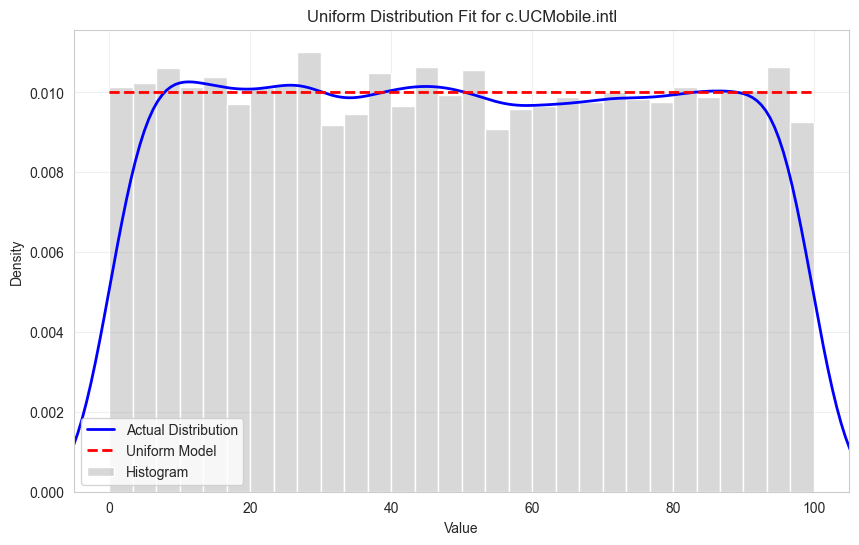

In [507]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Fit the uniform distribution
a = x86_data.min()
b = x86_data.max()
x = np.linspace(a, b, x86_data.size)
uniform_dist = stats.uniform(loc=a, scale=b - a)

# Plot histogram, KDE and uniform distribution
sns.histplot(data=x86_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=x86_data, color="blue", label="Actual Distribution", linewidth=2)
plt.plot(x, uniform_dist.pdf(x), color="red", linestyle="--", linewidth=2, label="Uniform Model")

# Customizing the plot
plt.title("Uniform Distribution Fit for c.UCMobile.intl")
plt.xlim(-5, 105)
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
x86_skew = stats.skew(x86_data)
print(f"Skewness of c.UCMobile.x86: {x86_skew}")

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=x86_data)

# Customizing the plot
plt.title("Boxplot of c.UCMobile.x86")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

### c.updateassist


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(updateassist_data, bins=30, kde=True)
plt.axvline(updateassist_mean, color="r", linestyle="--", label=f"Mean: {updateassist_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.updateassist")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

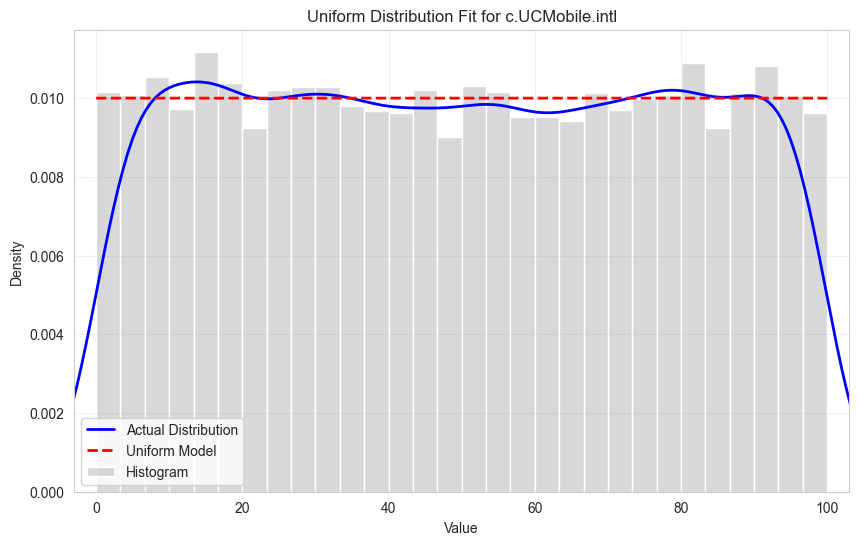

In [506]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Fit the uniform distribution
a = updateassist_data.min()
b = updateassist_data.max()
x = np.linspace(a, b, updateassist_data.size)
uniform_dist = stats.uniform(loc=a, scale=b - a)

# Plot histogram, KDE and uniform distribution
sns.histplot(data=updateassist_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=updateassist_data, color="blue", label="Actual Distribution", linewidth=2)
plt.plot(x, uniform_dist.pdf(x), color="red", linestyle="--", linewidth=2, label="Uniform Model")

# Customizing the plot
plt.title("Uniform Distribution Fit for c.UCMobile.intl")
plt.xlim(-5, 105)
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
updateassist_skew = stats.skew(updateassist_data)
print(f"Skewness of c.updateassist: {updateassist_skew}")

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=updateassist_data)

# Customizing the plot
plt.title("Boxplot of c.updateassist")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

### c.UCMobile.intl


In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram and KDE for the data
sns.histplot(intl_data, bins=30, kde=True)
plt.axvline(intl_mean, color="r", linestyle="--", label=f"Mean: {intl_mean:.2f}")

# Customizing the plot
plt.title("Distribution of c.UCMobile.intl")
plt.xlabel("Time active")
plt.ylabel("Numbers of occurrences")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
mu, std = stats.norm.fit(intl_data)

# Create the histogram using seaborn
sns.histplot(data=intl_data, bins=30, stat="density", kde="True", color="r")

# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)

plt.plot(x, p, "k", linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
plt.show()

In [ ]:
intl_skew = stats.skew(intl_data)
print(f"Skewness of c.UCMobile.intl: {intl_skew}")

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(data=intl_data)

# Customizing the plot
plt.title("Boxplot of c.UCMobile.intl")
plt.xlabel("Numbers of occurrences")
plt.ylabel("Time active")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Fit the uniform distribution
a = intl_data.min()
b = intl_data.max()
x = np.linspace(a, b, intl_data.size)
uniform_dist = stats.uniform(loc=a, scale=b - a)

# Plot histogram, KDE and uniform distribution
sns.histplot(data=intl_data, bins=30, stat="density", alpha=0.3, color="gray", label="Histogram")
sns.kdeplot(data=intl_data, color="blue", label="Actual Distribution", linewidth=2)
plt.plot(x, uniform_dist.pdf(x), color="red", linestyle="--", linewidth=2, label="Uniform Model")

# Customizing the plot
plt.title("Uniform Distribution Fit for c.UCMobile.intl")
plt.xlim(-5, 105)
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()